### MINST-Digit Recognizer

This Notebook is for only training the model, testing model accuracy with hyperparameters, this is not for EDA.

In [1]:
import pandas as pd
import numpy as np
import torch

import os

import torch.nn as nn   
import torch.nn.functional as F
from torchvision  import datasets 
from torch.utils.data import Dataset,DataLoader ,ConcatDataset
from torchvision import transforms
import matplotlib.pyplot as plt

from torch.utils.data import random_split, SubsetRandomSampler


Data is downloaded from Kaggle Dataset, link :https://www.kaggle.com/c/digit-recognizer/data <br>
`train.csv` and `test.csv` are extracted to path `notebooks\data` path

Loading Dataset

In [2]:
train_df = pd.read_csv(os.path.join("notebooks","data","train.csv"))
test_df = pd.read_csv(os.path.join("notebooks","data","test.csv"))


In [3]:
image_size = 28


In [4]:
train_df.head(5)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.label.unique()


array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

Plotting Images

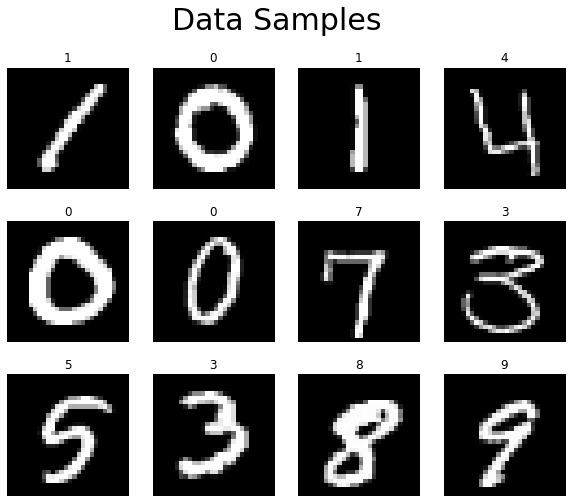

In [6]:
nrows = 3
ncols = 4
fig, axes = plt.subplots(nrows,ncols,figsize=(10,8))
i=0

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].imshow(train_df.iloc[i,1:].values.reshape(28,28),cmap='gray')
        axes[row][col].set_title(train_df.iloc[i,0])
        axes[row][col].axis('off')
        i+=1

plt.suptitle('Data Samples', fontsize=30)
plt.show()


Custom Dataset Class

In [7]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [10]:
BATCH_SIZE = 100
VALID_SIZE = 0.15 # percentage of data for validation

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Creating datasets for training and validation
train_data = DatasetMNIST(train_df, transform=transform_train)
valid_data = DatasetMNIST(train_df, transform=transform_valid)

# Shuffling data and choosing data that will be used for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(VALID_SIZE * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

print(f"Length train: {len(train_idx)}")
print(f"Length valid: {len(valid_idx)}")


Length train: 35700
Length valid: 6300


In [11]:
# As we are deploying on server that does not have GPU, setting use_cuda to default False, disbale model to use GPU
use_cuda = False
print(use_cuda)


False


In [50]:
class Model(nn.Module):
    def __init__(self, in_channels =1 ,out_channels = 10):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=3,stride =1,padding=2)
        self.b1 = nn.BatchNorm2d(8)

        self.c2 = nn.Conv2d(in_channels = 8,out_channels=32,kernel_size=3,padding=2,stride=1)
        self.b2 = nn.BatchNorm2d(32)

        self.c3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=2)
        self.b3 = nn.BatchNorm2d(64)

        self.l1 = nn.Linear(64*5*5,1024)
        self.l2 = nn.Linear(1024,512)

        self.l4 = nn.Linear(512,128)

        self.l6 = nn.Linear(128,32)
        self.final = nn.Linear(32,out_channels)
        

    def forward(self,x):
        nodes =F.relu(self.b1(self.c1(x)))
        nodes = F.max_pool2d(nodes,2,2) # 1,14,14
    
        nodes = F.relu(self.b2(self.c2(nodes))) 
        nodes = F.max_pool2d(nodes,2,2) #1,8,8
        nodes = F.dropout(nodes,0.3)
        nodes = F.relu(self.b3(self.c3(nodes)))
        nodes = F.max_pool2d(nodes,2,2) # 1,5,5
        nodes = F.dropout(nodes,0.4)
        nodes = F.relu(self.l1(nodes.reshape(-1,64*5*5)))
        nodes = F.relu(self.l2(nodes))
        # nodes = F.relu(self.l3(nodes))
        nodes = F.dropout(nodes)
        nodes = F.relu(self.l4(nodes))
        nodes = self.final(F.relu(self.l6(nodes)))#F.relu(self.l5(nodes)))))
        return nodes


In [51]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(32, 32, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(2, 2),
#             nn.Dropout(0.25)
#         )
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(64, 64, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(2, 2),
#             nn.Dropout(0.25)
#         )
        
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.MaxPool2d(2, 2),
#             nn.Dropout(0.25)
#         )
        
#         self.fc = nn.Sequential(
#             nn.Linear(128, 10),
#         )
                
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
        
#         x = x.view(x.size(0), -1)
#         return self.fc(x)


In [77]:
model = Model()
print(model)

LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_on_gpu = False

size = 0
for layer in model.parameters():
    size +=torch.numel(layer)

print("--------------------\nTotal Number of Parameters :",size,'\n--------------------')


Model(
  (c1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (b1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (b2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (b3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_features=1600, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (l4): Linear(in_features=512, out_features=128, bias=True)
  (l6): Linear(in_features=128, out_features=32, bias=True)
  (final): Linear(in_features=32, out_features=10, bias=True)
)
--------------------
Total Number of Parameters : 2255466 
--------------------


In [85]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if self.min_validation_loss>validation_loss :
            # print(f"Loss increased from {self.min_validation_loss:.5f} to {validation_loss:.5f}")
            print("Loss changed.")
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif (self.min_validation_loss + self.min_delta)<=validation_loss:
            # print(f"Loss did not increase from {self.min_validation_loss:.5f} ")
            print("No change in loss.")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [86]:
def train_per_epoch(train_loader,model,optimizer,):
    model.train()
    running_loss = 0
    for data,label in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out,label)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item()
    return running_loss

def test_per_epoch(valid_loader,model,):
    valid_accuracy = 0
    valid_loss = 0
    with torch.no_grad():
        model.eval()
        for data,label in valid_loader:
            out = model(data)
            _,top_class = out.topk(1,dim=1)
            equals = top_class == label.view(*top_class.shape)
            valid_loss += criterion(out, label).item()
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()
    return valid_accuracy, valid_loss



In [87]:
epochs = 150
train_losses, valid_losses,valid_accuracy = [],[],[]
early_stopping = EarlyStopper(patience=5)
for e in range(epochs):
    train_loss = train_per_epoch(train_loader,model,optimizer)
    acc,valid_loss = test_per_epoch(valid_loader,model)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracy.append(acc)


    print(f"Epoch {e+1:3} | Training Loss {train_loss/len(train_loader):.5f}  | Test Loss {valid_loss/len(valid_loader):.5f} | ",
            f"Accuracy {acc/len(valid_loader):.5f}")

    if early_stopping(valid_loss):
        print("Terminating Model training, as there is no change in Loss.....")
        torch.save(model.state_dict(), os.path.join('notebooks',"Model_Parameters.pt"))
        break
    

Epoch   1 | Training Loss 2.30116  | Test Loss 2.30143 |  Accuracy 0.09492
Loss changed.
Epoch   2 | Training Loss 2.29916  | Test Loss 2.29830 |  Accuracy 0.09460
Loss changed.
Epoch   3 | Training Loss 2.29664  | Test Loss 2.29620 |  Accuracy 0.10127
Loss changed.
Epoch   4 | Training Loss 2.29352  | Test Loss 2.29288 |  Accuracy 0.11333
Loss changed.
Epoch   5 | Training Loss 2.29022  | Test Loss 2.28919 |  Accuracy 0.13127
Loss changed.
Epoch   6 | Training Loss 2.28618  | Test Loss 2.28484 |  Accuracy 0.14286
Loss changed.
Epoch   7 | Training Loss 2.28066  | Test Loss 2.27906 |  Accuracy 0.14762
Loss changed.
Epoch   8 | Training Loss 2.27443  | Test Loss 2.27222 |  Accuracy 0.15238
Loss changed.
Epoch   9 | Training Loss 2.26599  | Test Loss 2.26284 |  Accuracy 0.15159
Loss changed.
Epoch  10 | Training Loss 2.25450  | Test Loss 2.24958 |  Accuracy 0.15952
Loss changed.
Epoch  11 | Training Loss 2.24030  | Test Loss 2.23261 |  Accuracy 0.17635
Loss changed.
Epoch  12 | Training 